In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
import tree
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation
from omegaconf import OmegaConf
import importlib
import logging
import sys
from collections import defaultdict


from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from data import r3_diffuser
from data import digs_data_loader
from model import loss
from experiments import train_se3_diffusion

# Enable logging
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

INFO: Using numpy backend


In [2]:
# Reloads any code changes in the source file.
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(plotting)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [10]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'rosetta'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 1
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False

# Data settings
data_conf = conf.data
data_conf.rosetta.filtering.subset = 1
data_conf.rosetta.filtering.max_len = 260
data_conf.rosetta.scale_factor = 1.0

# Diffusion settings
diff_conf = conf.diffuser
diff_conf.diffuse_trans = True  # whether to diffuse translations
diff_conf.diffuse_rot = True  # whether to diffuse rotations

# Noise schedules
diff_conf.rot_schedule = 'linear'
diff_conf.trans_max_b = 20
diff_conf.trans_schedule = 'exponential'

# Print out the config
# print(OmegaConf.to_yaml(conf))

In [11]:
# Create experiment and data loaders
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)

se3_diff = exp.diffuser
r3_diff = se3_diff._r3_diffuser
so3_diff = se3_diff._so3_diffuser

# Extract Ca positions of protein structure.
train_iter = iter(train_loader)
next_item = next(train_iter)
res_mask = next_item['res_mask'][0, :]
ca_pos = next_item['atom37_pos'][0, :, 1, :][res_mask.bool()]

# SDE time parameters.
num_t = 100
forward_t = np.linspace(1e-3, 1, num_t)
reverse_t = forward_t[::-1]
dt = 1 / num_t

INFO: Number of model parameters 3703648
INFO: Using cached IGSO3.
INFO: Checkpoint not being saved.
INFO: Evaluation saved to: ./results/baseline/17D_09M_2022Y_05h_24m_44s
INFO: Training: 1 examples
INFO: Validation: 4 examples with lengths [152 152 152 152 152 152 152 152 152 152]


In [12]:
gt_rigids_0 = next_item['rigids_0'][0][next_item['res_mask'][0].bool()]
rigid_0 = ru.Rigid.from_tensor_7(gt_rigids_0)

### VE SDE

In [38]:

class R3Diffuser:
    """VE-SDE diffuser class for translations."""

    def __init__(
            self,
            min_sigma,
            max_sigma,
            schedule='linear',
        ):
        """
        Args:
            min_b: starting value in variance schedule.
            max_b: ending value in variance schedule.
        """
        self.min_sigma = min_sigma
        self.max_sigma = max_sigma 
        self._discrete_t = np.linspace(1e-5, 1, num_t)
        self.schedule = schedule

    def sigma_t(self, t):
        if np.any(t < 0) or np.any(t > 1):
            raise ValueError(f'Invalid t={t}')
        if self.schedule == 'linear': 
            return self.min_sigma * (self.max_sigma/self.min_sigma)**t
        else:
            raise ValueError(f'Unknown schedule {self.schedule}')

    def forward(
            self,
            x_t: np.ndarray,
            t: float,
            t_1: float):
        """Samples time t-1 from the forward process given time t.

        Args:
            t: continuous time in [0, 1]. 
            dt: time step interval.
            x_t: [..., 3] current positions at time t.

        Returns:
            x_t_1: [..., 3] positions at time t-1.
        """
        z = np.random.normal(size=x_t.shape)
        return x_t + np.sqrt(self.sigma_t(t)**2 - self.sigma_t(t_1)**2)*z

    def forward_marginal(self, x_0: np.ndarray, t: float, score_norm=True):
        """Samples marginal p(x(t) | x(0)).

        Args:
            x_0: [..., n, 3] initial positions.
            t: continuous time in [0, 1]. 

        Returns:
            x_t: [..., n, 3] positions at time t.
            score_t: [..., n, 3] score at time t.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t = np.random.normal(
            loc=x_0,
            scale=self.sigma_t(t)
        )
        return x_t


In [52]:
x_0 = rigid_0.get_trans() * 10.0

In [53]:
r3diff = R3Diffuser(
    min_sigma=0.01,
    max_sigma=20.0
)

In [54]:
forward_t = np.linspace(1e-3, 1, num_t)
reverse_t = forward_t[::-1]
dt = 1 / num_t

forward_t_1 = np.roll(forward_t, 1)
forward_t_1[0] = 0.0

In [55]:
# Forward diffusion
forward_rollout = [x_0]
for i,(t, t_1) in enumerate(zip(forward_t, forward_t_1)):
    x_t1 = r3diff.forward(
        forward_rollout[-1],
        t,
        t_1)
    forward_rollout.append(x_t1)

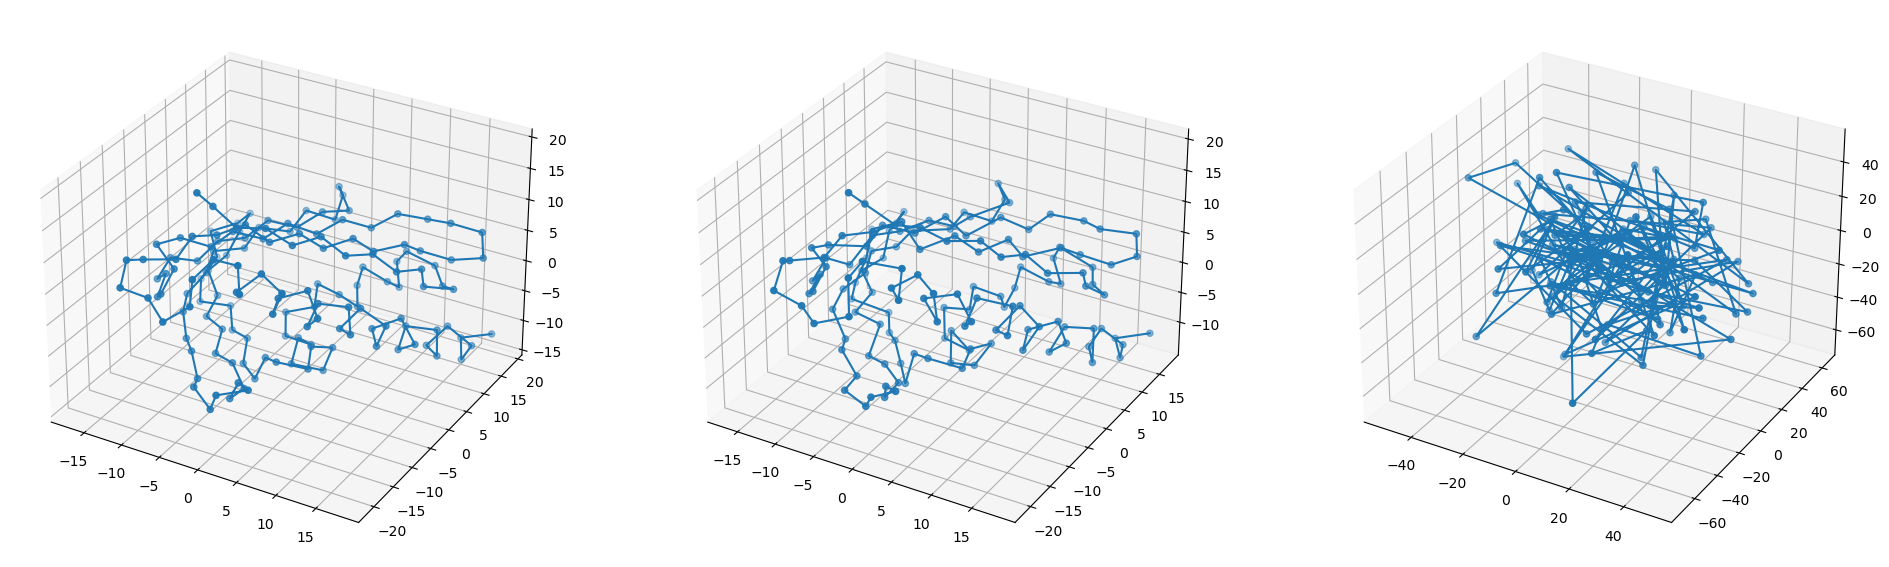

In [56]:
# Plot out SE(3)
init_pos = forward_rollout[0]
mid_pos = forward_rollout[-50]
final_pos = forward_rollout[-1]
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))

plotting.plt_3d(init_pos, axes[0], mode='scatter')
plotting.plt_3d(init_pos, axes[0], mode='line')

plotting.plt_3d(mid_pos, axes[1], mode='scatter')
plotting.plt_3d(mid_pos, axes[1], mode='line')

plotting.plt_3d(final_pos, axes[2], mode='scatter')
plotting.plt_3d(final_pos, axes[2], mode='line')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5], subplot_kw=dict(projection="3d"))

def extract_se3_vec(step, b_idx, scale_factor=10.0):
    frame = all_sampled_frames[step] * sample_mask[..., None] + data_raw['rigids_0'] * (1 - sample_mask[..., None])
    frame = frame[b_idx][bb_mask[b_idx]]
    se3_vec = au.rigids_to_se3_vec(du.move_to_np(frame), scale_factor=scale_factor)
    return se3_vec


_ = plotting.plot_se3(extract_se3_vec(0, b_idx), ax=ax, ax_lim=ax_lim)

def update(frame):
    ax.clear()
    plotting.plot_se3(extract_se3_vec(frame, b_idx), ax=ax, ax_lim=ax_lim)

anim = FuncAnimation(
    fig,
    update,
    frames=list(range(1, exp.diffuser.num_steps)),
    interval=10,
    blit=False)
writergif = animation.PillowWriter(fps=30) 
# f = f'/data/rsg/chemistry/jyim/protein_diffusion_samples/se3_diffusion/dev_diffusion_{b_idx}.gif'
f = f'dev_diffusion_{b_idx}.gif'
anim.save(f, writer=writergif)

In [ ]:
# TODO: Incorporate animations
def create_animation(b_idx, all_sampled_frames, sample_mask, data_raw):
    ax_lim = 10

    fig, ax = plt.subplots(1, 1, figsize=[5, 5], subplot_kw=dict(projection="3d"))
    bb_mask = du.move_to_np(data_raw['res_mask']).astype(bool)

    def extract_se3_vec(step, b_idx, scale_factor=10.0):
        frame = all_sampled_frames[step] * sample_mask[..., None] + data_raw['rigids_0'] * (1 - sample_mask[..., None])
        frame = frame[b_idx][bb_mask[b_idx]]
        se3_vec = au.rigids_to_se3_vec(du.move_to_np(frame), scale_factor=scale_factor)
        return se3_vec


    _ = plotting.plot_se3(extract_se3_vec(0, b_idx), ax=ax, ax_lim=ax_lim)

    def update(frame):
        ax.clear()
        plotting.plot_se3(extract_se3_vec(frame, b_idx), ax=ax, ax_lim=ax_lim)

    anim = FuncAnimation(
        fig,
        update,
        frames=list(range(1, exp.diffuser.num_steps)),
        interval=10,
        blit=False)
    writergif = animation.PillowWriter(fps=30) 
    # f = f'/data/rsg/chemistry/jyim/protein_diffusion_samples/se3_diffusion/dev_diffusion_{b_idx}.gif'
    f = f'dev_diffusion_{b_idx}.gif'
    anim.save(f, writer=writergif)
    print(f'Saved gif to: {f}')

# Matching forward and reverse

## Translations

Check that the marginals of the forward diffusion match the reverse.

In [92]:
# Forward diffusion
x_0 = np.ones((1, 3))
marginal_samples = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    for _ in range(500):
        marginal_samples[i].append(
            r3_diff.forward_marginal(x_0, t)[0]
        )

In [93]:
# Reverse diffusion
reverse_samples = {}
for _ in range(500):
    curr_step = r3_diff.sample_ref(n_samples=1)
    for i, t in reversed(list(enumerate(forward_t))):
        if i not in reverse_samples:
            reverse_samples[i] = []
        score_t = r3_diff.score(
            curr_step,
            x_0,
            t)
        curr_step = r3_diff.reverse(
            x_t=curr_step,
            score_t=score_t,
            t=t,
            dt=dt,
            center=False
        )
        reverse_samples[i].append(
            copy.deepcopy(curr_step)
        )

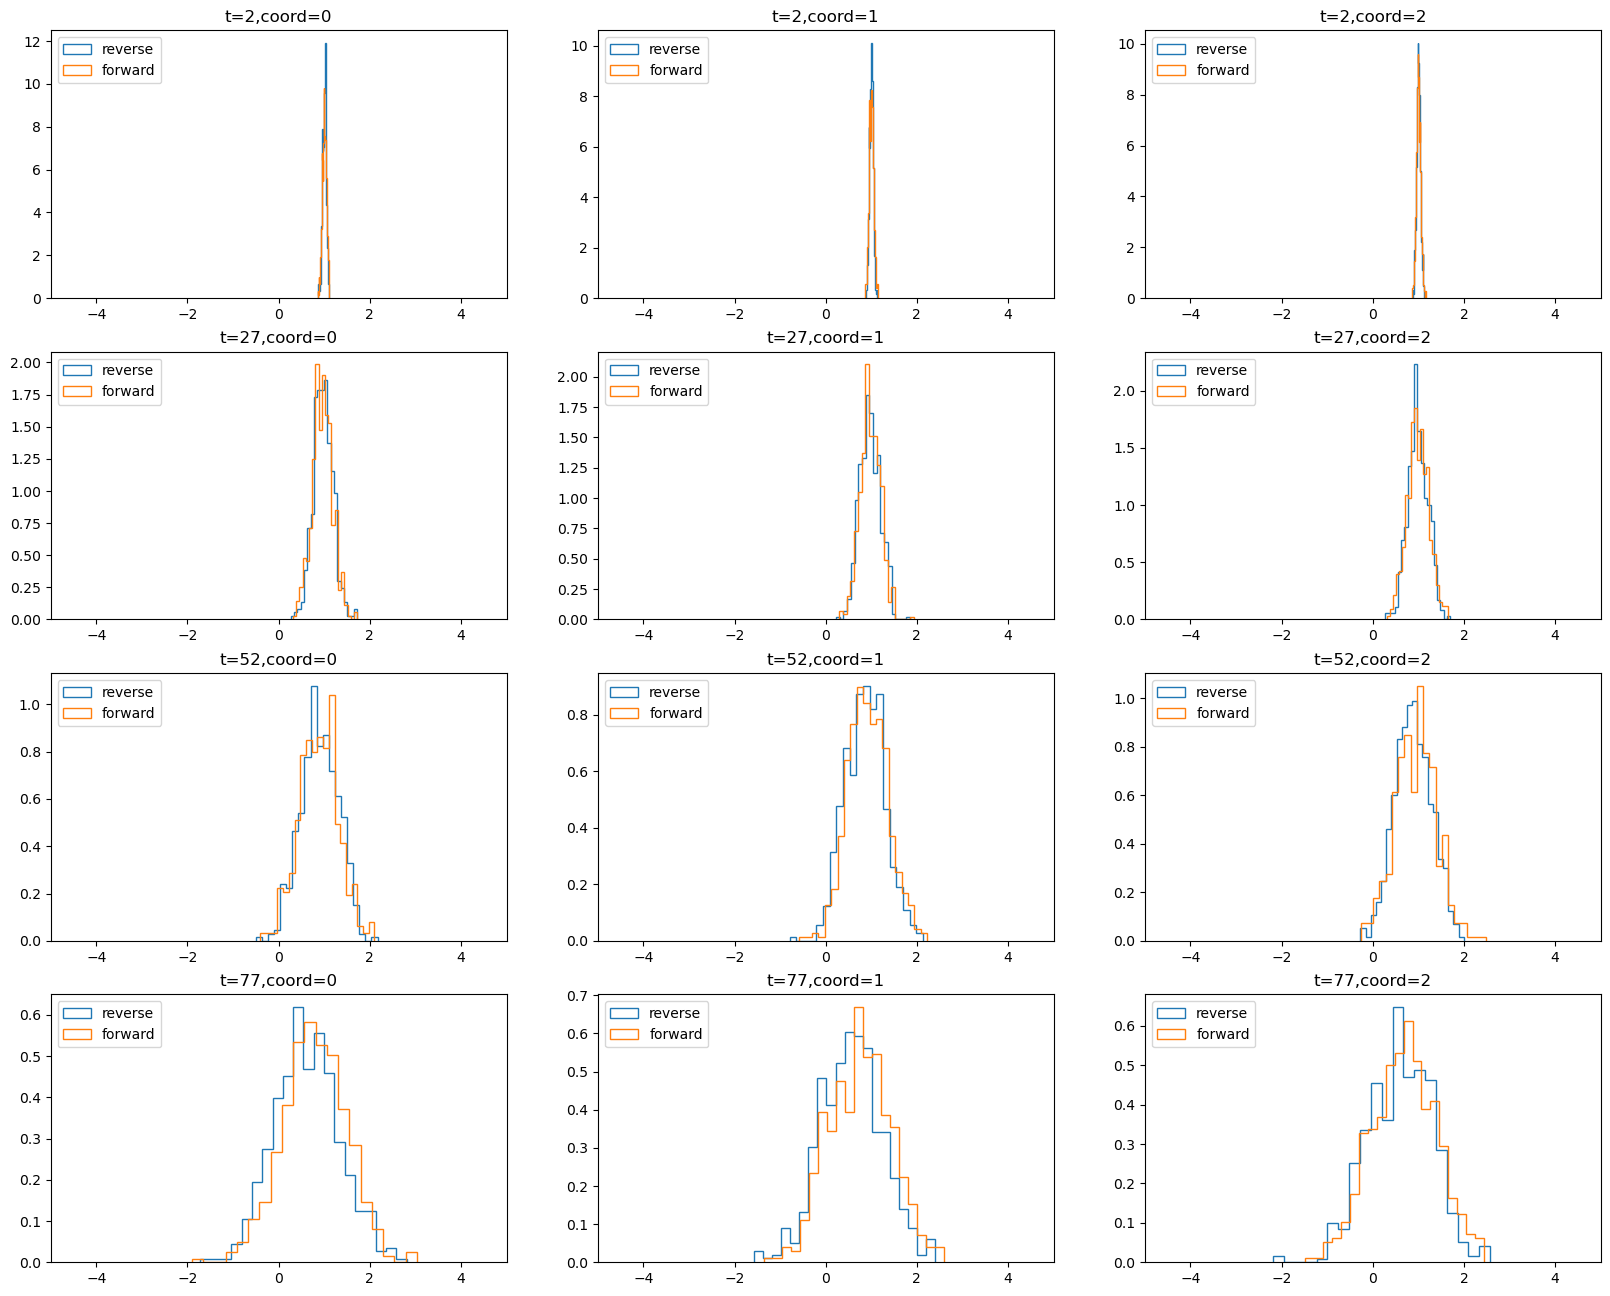

In [94]:
ts = np.arange(2, num_t, num_t//4)
f, axes = plt.subplots(len(ts), 3, figsize=[20, 4*len(ts)])
for i,t in enumerate(ts):
    for j in range(3):
        reverse_i = np.stack(reverse_samples[t])[:, 0, j]
        axes[i, j].hist(reverse_i, bins=20, density=True, label='reverse', histtype='step')

        forward_i = np.stack(marginal_samples[t])[:, 0, j]
        axes[i, j].hist(forward_i, bins=20, density=True, label='forward', histtype='step')

        axes[i, j].set_xlim(-5, 5)
        axes[i, j].set_title(f't={t},coord={j}')
        axes[i, j].legend(loc="upper left")


## Rotations

Check that the marginals of the forward diffusion match the reverse.

In [23]:
# Forward diffusion
rot_0 = np.zeros((1, 3))
marginal_samples = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    for _ in range(500):
        marginal_samples[i].append(
            so3_diff.forward_marginal(rot_0, t)[0])

In [6]:
# Reverse diffusion
reverse_samples = {}
for _ in range(500):
    curr_step = so3_diff.sample_ref(n_samples=1)
    for i, t in reversed(list(enumerate(forward_t))):
        if i not in reverse_samples:
            reverse_samples[i] = []
        score_t = so3_diff.score(curr_step, t)
        curr_step = so3_diff.reverse(
            rot_t=curr_step,
            score_t=score_t,
            t=t,
            dt=dt)
        reverse_samples[i].append(copy.deepcopy(curr_step))

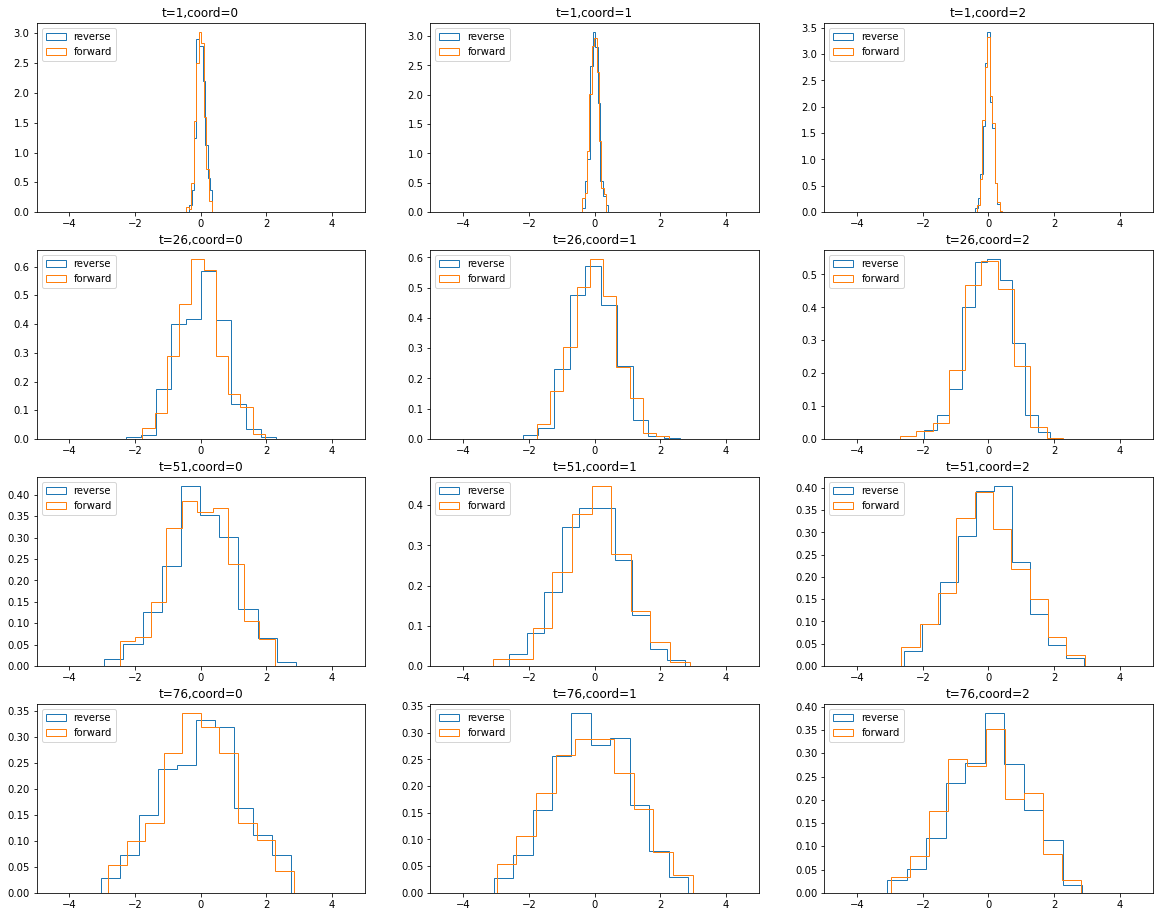

In [7]:
ts = np.arange(1, num_t, num_t//4)
f, axes = plt.subplots(len(ts), 3, figsize=[20, 4*len(ts)])
for i,t in enumerate(ts):
    for j in range(3):
        reverse_i = np.stack(reverse_samples[t])[:, 0, j]
        axes[i, j].hist(reverse_i, bins=10, density=True, label='reverse', histtype='step')

        forward_i = np.stack(marginal_samples[t])[:, 0, j]
        axes[i, j].hist(forward_i, bins=10, density=True, label='forward', histtype='step')

        axes[i, j].set_xlim(-5, 5)
        axes[i, j].set_title(f't={t},coord={j}')
        axes[i, j].legend(loc="upper left")


## Rigid bodies

In [19]:
# Forward diffusion
num_res = 5
rigid_0 = ru.Rigid(
    rots=ru.Rotation(
        rot_mats=torch.Tensor(
            Rotation.from_rotvec(
                np.zeros((num_res, 3))
            ).as_matrix()
        )
    ),
    trans=torch.normal(0, 1, size=(num_res, 3))
)
    
marginal_samples = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    for _ in range(500):
        marginal_samples[i].append(
            se3_diff.forward_marginal(rigid_0, t)[0].to_tensor_7())

In [23]:
# Reverse diffusion
reverse_samples = {}
for _ in range(500):
    curr_step = se3_diff.sample_ref(n_samples=num_res)
    for i, t in reversed(list(enumerate(forward_t))):
        if i not in reverse_samples:
            reverse_samples[i] = []
        trans_score, rot_score = se3_diff.score(rigid_0, curr_step, t)
        curr_step = se3_diff.reverse(
            rigid_t=curr_step,
            rot_score=rot_score,
            trans_score=trans_score,
            t=t,
            dt=dt,
            center=False
        )
        reverse_samples[i].append(copy.deepcopy(curr_step.to_tensor_7()))

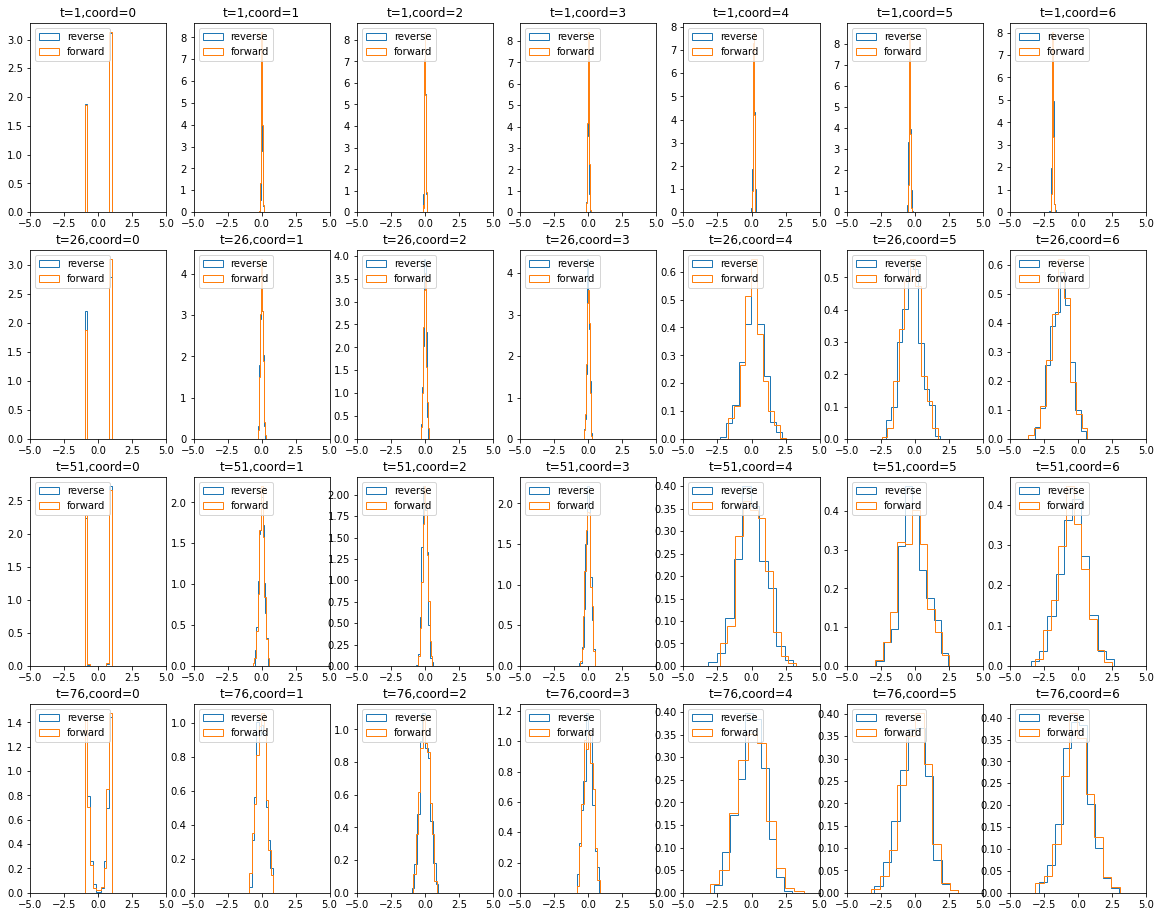

In [24]:
ts = np.arange(1, num_t, num_t//4)
num_coords = 7
f, axes = plt.subplots(len(ts), num_coords, figsize=[20, 4*len(ts)])
for i,t in enumerate(ts):
    for j in range(num_coords):
        reverse_i = np.stack(reverse_samples[t])[:, 0, j]
        axes[i, j].hist(reverse_i, bins=10, density=True, label='reverse', histtype='step')

        forward_i = np.stack(marginal_samples[t])[:, 0, j]
        axes[i, j].hist(forward_i, bins=10, density=True, label='forward', histtype='step')

        axes[i, j].set_xlim(-5, 5)
        axes[i, j].set_title(f't={t},coord={j}')
        axes[i, j].legend(loc="upper left")


# Real protein

In [13]:
se3_diff._diffuse_trans = True
# Provides true rotations if False.
# Note setting this to True when the true rotation is known doesn't work in our set-up.
se3_diff._diffuse_rot = False  

In [14]:
gt_rigids_0 = next_item['rigids_0'][0][next_item['res_mask'][0].bool()]
rigid_0 = ru.Rigid.from_tensor_7(gt_rigids_0)
# rigid_0 = rigid_0.apply_trans_fn(lambda x: x*10.)

In [15]:
# Reverse diffusion starting from should match real protein.
all_steps = []
curr_step = se3_diff.sample_ref(n_samples=gt_rigids_0.shape[0], impute=rigid_0)
for i, t in reversed(list(enumerate(forward_t))):
    trans_score, rot_score = se3_diff.score(rigid_0, curr_step, t)
    curr_step = se3_diff.reverse(
        rigid_t=curr_step,
        rot_score=rot_score,
        trans_score=trans_score,
        t=t,
        dt=dt,
        center=True
    )
    all_steps.append(copy.deepcopy(curr_step.to_tensor_7()))

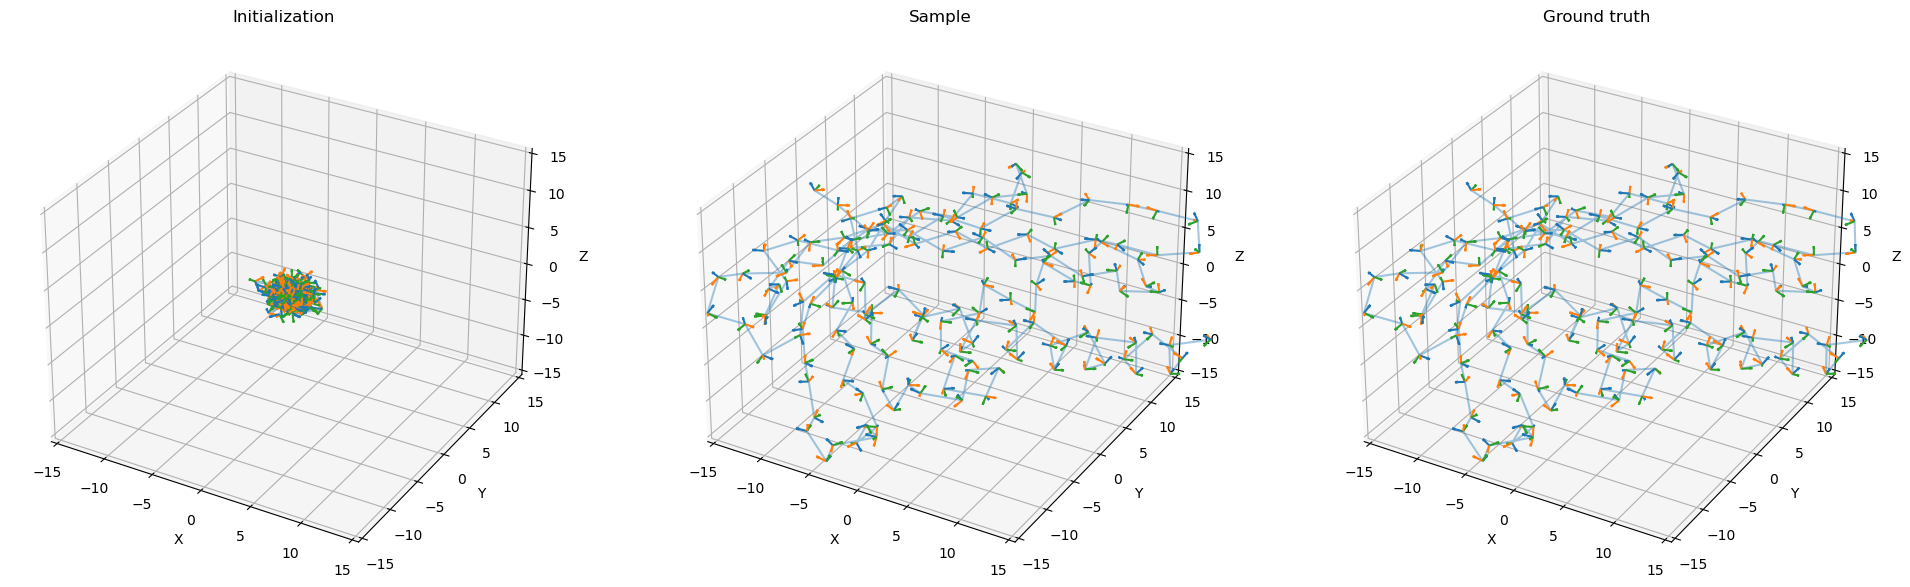

In [16]:
# Plot out SE(3)
initial_rigid = all_steps[0]
final_rigid = all_steps[-2]
res_mask = torch.ones(final_rigid.shape[0])
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
# scale_factor = conf.data.digs.scale_factor
scale_factor = 1.0
ax_lim = 15
plotting.viz_frames(initial_rigid, res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(final_rigid, res_mask, axes[1], title='Sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(rigid_0.to_tensor_7(), res_mask, axes[2], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)

INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


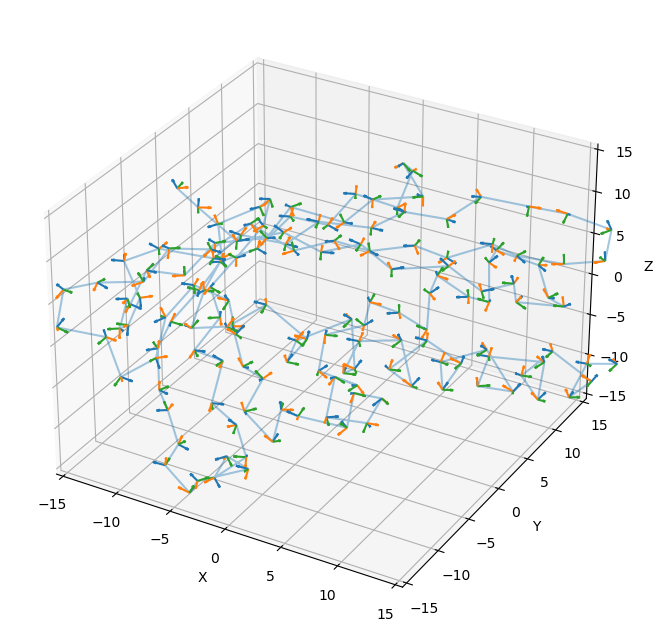

In [17]:
plotting.write_traj(torch.stack(all_steps), 'traj_3.gif', scale_factor=scale_factor)

In [ ]:
create_animation(0, sample_steps, torch.ones_like(res_mask), data_feats)

In [ ]:
# TODO: Incorporate animations
def create_animation(b_idx, all_sampled_frames, sample_mask, data_raw):
    ax_lim = 10

    fig, ax = plt.subplots(1, 1, figsize=[5, 5], subplot_kw=dict(projection="3d"))
    bb_mask = du.move_to_np(data_raw['res_mask']).astype(bool)

    def extract_se3_vec(step, b_idx, scale_factor=10.0):
        frame = all_sampled_frames[step] * sample_mask[..., None] + data_raw['rigids_0'] * (1 - sample_mask[..., None])
        frame = frame[b_idx][bb_mask[b_idx]]
        se3_vec = au.rigids_to_se3_vec(du.move_to_np(frame), scale_factor=scale_factor)
        return se3_vec


    _ = plotting.plot_se3(extract_se3_vec(0, b_idx), ax=ax, ax_lim=ax_lim)

    def update(frame):
        ax.clear()
        plotting.plot_se3(extract_se3_vec(frame, b_idx), ax=ax, ax_lim=ax_lim)

    anim = FuncAnimation(
        fig,
        update,
        frames=list(range(1, exp.diffuser.num_steps)),
        interval=10,
        blit=False)
    writergif = animation.PillowWriter(fps=30) 
    # f = f'/data/rsg/chemistry/jyim/protein_diffusion_samples/se3_diffusion/dev_diffusion_{b_idx}.gif'
    f = f'dev_diffusion_{b_idx}.gif'
    anim.save(f, writer=writergif)
    print(f'Saved gif to: {f}')

In [ ]:
# 